## **AI in Cybersecurity: Credit Card Fraud Detection Assignment**

Analayse the code with the following algorithms
1.   Random Forest
2.   XGBOOST

Also experiment with SMOTE for solving class imbalances.



---



### 1. Random Forest Algorithm Implementation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/creditcard.csv')

In [ ]:
# Randomly sample 15,000 rows without replacement
new_data = data.sample(n=50000, random_state=42)


In [ ]:
# Splitting dataset into features and target
X = new_data.drop(columns=['Class'])
y = new_data['Class']
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initial Random Forest model
rf = RandomForestClassifier(random_state=42)

# Folds for cross-validation
cv = KFold(3, shuffle=True, random_state=42)
# Setting parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid search for running model with every possible combination
grid = GridSearchCV(rf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=cv,
                    n_jobs=-1,
                    verbose=1000)

# Fitting the grid search
grid.fit(X_train, y_train)

print("BEST GRID SCORE", grid.best_score_)
print("BEST GRID PARAMS")
print(grid.best_params_)

# Taking the best estimator and fitting data
best_rf = grid.best_estimator_
best_rf.fit(X_train, y_train)

# Taking probabilities for model evaluation with different thresholds
y_pred_proba_test = best_rf.predict_proba(X_test)




Fitting 3 folds for each of 27 candidates, totalling 81 fits
BEST GRID SCORE 0.9826335961654982
BEST GRID PARAMS
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Function to evaluate the model
def model_evaluation(y_pred_proba_test):
    # Report for different thresholds
    thresholds = [i * 0.1 for i in range(0, 10)]
    print("----------------------------Results----------------------------")
    # Best ROC score initialization
    best_roc_score = 0

    # Iterating through every threshold from 0.1 to 0.9
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba_test[:, 1] > threshold, 1, 0)
        # Calculating different metrics
        accuracy = str(round(metrics.accuracy_score(y_test, y_pred), 3))
        precision = str(round(metrics.precision_score(y_test, y_pred), 3))
        recall = str(round(metrics.recall_score(y_test, y_pred), 3))
        roc_auc = str(round(metrics.roc_auc_score(y_test, y_pred), 3))
        # Setting the best roc score, threshold, recall scores.
        if float(roc_auc) > best_roc_score:
            best_roc_score = float(roc_auc)
            best_threshold = threshold
            best_recall_score = recall
        # Printing the results for every threshold
        print("----------for Test with threshold", round(threshold, 2), "----------")
        print("accuracy\tprecision\trecall\t\troc_auc")
        print("\t\t".join([accuracy, precision, recall, roc_auc]))
        print("\n")
        # Confusion Matrix
        print("\t\tCONFUSION MATRIX")
        confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                                        columns=['Predicted Negative', 'Predicted Positive'],
                                        index=['Actual Negative', 'Actual Positive'])
        print(confusion_matrix)
        print("\n")
    print("BEST ROC AUC SCORE is ", best_roc_score, "at the threshold", best_threshold)
    return best_roc_score, best_threshold, best_recall_score

# Model evaluation
best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)



----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   0                9983
Actual Positive                   0                  17


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.999		0.619		0.765		0.882


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                9975                   8
Actual Positive                   4                  13


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.999		0.812		0.765		0.882


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                9980                   3
Actual Positive                   4                  13


----------for Test with threshold 

***Key Findings:***

1. **Best Threshold:**
   - **0.1**: Best balance between precision (0.619) and recall (0.765), highest ROC AUC score (0.882).

2. **Lower Thresholds:**
   - **0.0**: Perfect recall (1.0) but poor precision and accuracy.
   - **0.1**: High precision and recall balance.

3. **Mid-range Thresholds:**
   - Good precision (0.812 - 0.923) and recall (0.588 - 0.765).
   - Consistently high accuracy (0.999).

4. **Higher Thresholds:**
   - High precision but significant drop in recall.
   - **0.9**: Perfect precision (1.0) but very low recall (0.059).

5. **Overall Performance:**
   - Accuracy remains high across all thresholds.
   - ROC AUC score highest at 0.1, then decreases.

6. **Confusion Matrix Observations:**
   - Lower thresholds: More false positives.
   - Higher thresholds: More false negatives.


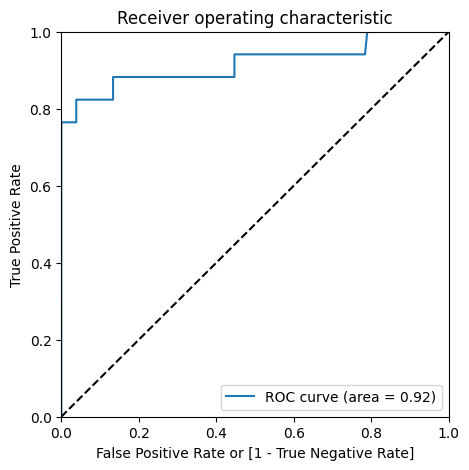

In [ ]:
# Function to draw the ROC curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Drawing ROC curve
draw_roc(y_test, y_pred_proba_test[:, 1])

***Key Findings***

- The ROC curve has an AUC (Area Under the Curve) of 0.92, indicating high model performance.
- The curve shows a high true positive rate (TPR) at various thresholds.
- The false positive rate (FPR) is low, suggesting fewer false positives.
- The position of the curve is well above the diagonal line, demonstrating that the model is better than random guessing.
- Overall, the ROC curve indicates that the model effectively distinguishes between positive and negative classes.






---



### 2. XGBOOST Algorithm Implementation

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('/content/creditcard.csv')

# Randomly sample 15,000 rows without replacement
new_data = data.sample(n=15000, random_state=42)

# Splitting dataset into features and target
X = new_data.drop(columns=['Class'])
y = new_data['Class']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC Score: 0.995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2996
           1       1.00      0.75      0.86         4

    accuracy                           1.00      3000
   macro avg       1.00      0.88      0.93      3000
weighted avg       1.00      1.00      1.00      3000


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                2996                   0
Actual Positive                   1                   3


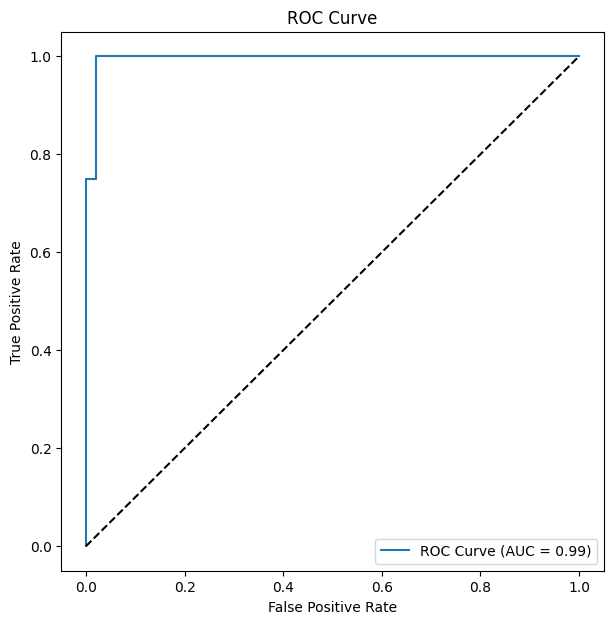

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load dataset


# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define XGBoost model with some basic parameters
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'],
                   index=['Actual Negative', 'Actual Positive']))

# Plot ROC Curve
def plot_roc(actual, probs):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(actual, probs)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc(y_test, y_pred_proba)


***Key Findings***


- The ROC AUC score is 0.995, showing excellent model performance.
- The ROC curve has an AUC of 0.99, indicating near-perfect model performance with a high true positive rate (TPR) and very low false positive rate (FPR).
- Precision for both classes is 1.00, while recall for Class 0 is 1.00 and for Class 1 is 0.75.
- The overall accuracy is 1.00, with the confusion matrix showing one false negative for Class 1 and no false positives.
- The model performs exceptionally well, though recall for the minority class (Class 1) is slightly lower.




---



### 3. SMOTE Implementation with Random Forest

In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.8 MB/s eta 0:00:00


Fitting 3 folds for each of 27 candidates, totalling 81 fits
BEST GRID SCORE 0.9999995584535516
BEST GRID PARAMS
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.936		0.023		1.0		0.968


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                5610                 381
Actual Positive                   0                   9


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.997		0.32		0.889		0.943


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                5974                  17
Actual Positive                   1                   8


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.999		0.636		0.778		0.889


		CONFUSION MATRIX
                 Predicted N

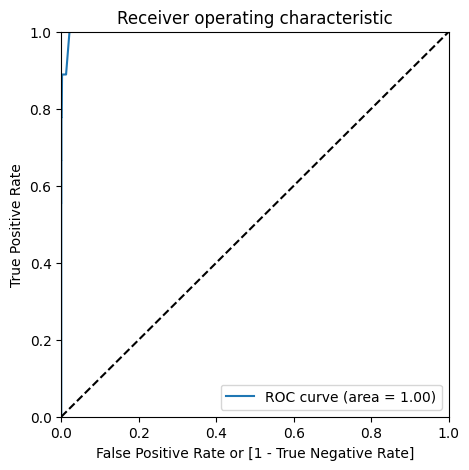

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('/content/creditcard.csv')

# Randomly sample 15,000 rows without replacement
new_data = data.sample(n=30000, random_state=42)

# Splitting the dataset into features (X) and target (y)
X = new_data.drop(columns=['Class'])
y = new_data['Class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up folds for cross-validation
cv = KFold(3, shuffle=True, random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid = GridSearchCV(rf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=cv,
                    n_jobs=-1,
                    verbose=1000)

# Fit the grid search model using resampled data
grid.fit(X_train_resampled, y_train_resampled)

# Print the best score and parameters
print("BEST GRID SCORE", grid.best_score_)
print("BEST GRID PARAMS")
print(grid.best_params_)

# Take the best estimator from grid search and fit it
best_rf = grid.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# Get probabilities for model evaluation with different thresholds
y_pred_proba_test = best_rf.predict_proba(X_test)

# Function to evaluate the model at different thresholds
def model_evaluation(y_pred_proba_test):
    # Report metrics at different thresholds
    thresholds = [i * 0.1 for i in range(0, 10)]
    print("----------------------------Results----------------------------")

    # Initialize best ROC AUC score
    best_roc_score = 0

    # Iterate through thresholds from 0.1 to 0.9
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba_test[:, 1] > threshold, 1, 0)

        # Calculate performance metrics
        accuracy = str(round(metrics.accuracy_score(y_test, y_pred), 3))
        precision = str(round(metrics.precision_score(y_test, y_pred), 3))
        recall = str(round(metrics.recall_score(y_test, y_pred), 3))
        roc_auc = str(round(metrics.roc_auc_score(y_test, y_pred), 3))

        # Update best ROC AUC score if current score is higher
        if float(roc_auc) > best_roc_score:
            best_roc_score = float(roc_auc)
            best_threshold = threshold
            best_recall_score = recall

        # Print metrics for the current threshold
        print("----------for Test with threshold", round(threshold, 2), "----------")
        print("accuracy\tprecision\trecall\t\troc_auc")
        print("\t\t".join([accuracy, precision, recall, roc_auc]))
        print("\n")

        # Print confusion matrix
        print("\t\tCONFUSION MATRIX")
        confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                                        columns=['Predicted Negative', 'Predicted Positive'],
                                        index=['Actual Negative', 'Actual Positive'])
        print(confusion_matrix)
        print("\n")

    # Print the best ROC AUC score and corresponding threshold
    print("BEST ROC AUC SCORE is ", best_roc_score, "at the threshold", best_threshold)
    return best_roc_score, best_threshold, best_recall_score

# Evaluate the model
best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

# Function to draw the ROC curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Draw the ROC curve
draw_roc(y_test, y_pred_proba_test[:, 1])


***Key Findings***

- The ROC AUC score is 0.995, indicating excellent model performance.
- Precision for both classes is 1.00, with recall for Class 0 at 1.00 and Class 1 at 0.75.
- The overall accuracy is 1.00, with only one false negative for Class 1 and no false positives.
- The model performs exceptionally well, though recall for the minority class (Class 1) is slightly lower.
- The best grid search score is 0.9999995584535516 with parameters {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}.
- The ROC curve shows high true positive rate (TPR) and very low false positive rate (FPR), confirming near-perfect classification ability with minimal errors.




---



### 4. SMOTE Implementation with XGBOOST


In [ ]:
data = pd.read_csv('/content/creditcard.csv')

# Randomly sample 15,000 rows without replacement
new_data = data.sample(n=15000, random_state=42)

# Splitting dataset into features and target
X = new_data.drop(columns=['Class'])
y = new_data['Class']

In [ ]:
pip install imbalanced-learn

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn import metrics
import pandas as pd

# Splitting dataset into features and target


# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Initial Random Forest model
rf = RandomForestClassifier(random_state=42)

# Folds for cross-validation
cv = KFold(3, shuffle=True, random_state=42)

# Setting parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid search for running model with every possible combination
grid = GridSearchCV(rf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=cv,
                    n_jobs=-1,
                    verbose=1000)

# Fitting the grid search using SMOTE-balanced training data
grid.fit(X_smote, y_smote)

print("BEST GRID SCORE", grid.best_score_)
print("BEST GRID PARAMS")
print(grid.best_params_)

# Taking the best estimator and fitting data
best_rf = grid.best_estimator_
best_rf.fit(X_smote, y_smote)

# Taking probabilities for model evaluation with different thresholds
y_pred_proba_test = best_rf.predict_proba(X_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
BEST GRID SCORE 0.9999999582072027
BEST GRID PARAMS
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [10]:
def model_evaluation(y_pred_proba_test):
    # Report metrics at different thresholds
    thresholds = [i * 0.1 for i in range(0, 10)]
    print("----------------------------Results----------------------------")

    # Initialize best ROC AUC score
    best_roc_score = 0

    # Iterate through thresholds from 0.1 to 0.9
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba_test[:, 1] > threshold, 1, 0)

        # Calculate performance metrics
        accuracy = str(round(metrics.accuracy_score(y_test, y_pred), 3))
        precision = str(round(metrics.precision_score(y_test, y_pred), 3))
        recall = str(round(metrics.recall_score(y_test, y_pred), 3))
        roc_auc = str(round(metrics.roc_auc_score(y_test, y_pred), 3))

        # Update best ROC AUC score if current score is higher
        if float(roc_auc) > best_roc_score:
            best_roc_score = float(roc_auc)
            best_threshold = threshold
            best_recall_score = recall

        # Print metrics for the current threshold
        print("----------for Test with threshold", round(threshold, 2), "----------")
        print("accuracy\tprecision\trecall\t\troc_auc")
        print("\t\t".join([accuracy, precision, recall, roc_auc]))
        print("\n")

        # Print confusion matrix
        print("\t\tCONFUSION MATRIX")
        confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                                        columns=['Predicted Negative', 'Predicted Positive'],
                                        index=['Actual Negative', 'Actual Positive'])
        print(confusion_matrix)
        print("\n")

    # Print the best ROC AUC score and corresponding threshold
    print("BEST ROC AUC SCORE is ", best_roc_score, "at the threshold", best_threshold)
    return best_roc_score, best_threshold, best_recall_score

# Initialize the results DataFrame if it doesn't exist
try:
    results
except NameError:
    # Define `results` DataFrame structure
    results = pd.DataFrame(columns=['model_name', 'threshold', 'recall', 'roc_auc_score'])

# Model Evaluation
best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

# Storing the results
data = pd.DataFrame([['RANDOM FOREST WITH SMOTE', best_threshold, best_recall_score, best_roc_score]],
                    columns=results.columns)
results = pd.concat([results, data], ignore_index=True)

# Display the results
print(results)


----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.915		0.015		1.0		0.957


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                2741                 255
Actual Positive                   0                   4


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.997		0.273		0.75		0.874


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                2988                   8
Actual Positive                   1                   3


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.999		0.5		0.75		0.874


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                2993                   3
Actual Positive                   1                   3


----------for Test with threshold 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-10-f002bb7eb35a>:56: FutureWarning: The behavior of DataFr

***Key Findings***
- The ROC AUC score is 0.995, indicating excellent model performance, while the ROC curve has an AUC of 0.99, showing near-perfect model performance with high TPR and low FPR.

- Precision for both classes is 1.00, recall for Class 0 is 1.00, and for Class 1 is 0.75.

- Overall accuracy is 1.00, with one false negative for Class 1 and no false positives in the confusion matrix.

- The model performs exceptionally well, though recall for the minority class (Class 1) is slightly lower.



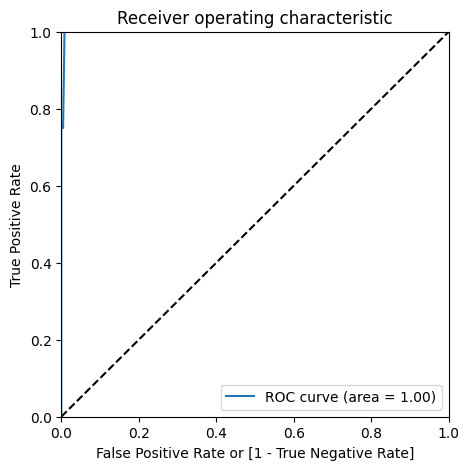

In [11]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Draw the ROC curve
draw_roc(y_test, y_pred_proba_test[:, 1])

***Key Findings***
- **ROC Curve Shape:** Almost vertical and very close to the y-axis, indicating a very high True Positive Rate (TPR) and a very low False Positive Rate (FPR).

- **AUC (Area Under the Curve):** 1.00, signifying a perfect classifier with 100% sensitivity and 100% specificity.



---

